In [4]:
import os
import numpy as np
import pandas as pd
import supervision as sv
from supervision.metrics import MeanAveragePrecision

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# Configuration files
model_configs = [
    {
        'train': 'Delhi NCR',
        'test': 'West Bengal',
        'backbone': 'swint',
        'head': 'rhino',
        'config_file': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/configs-mine/rhino-swint-dota2config/rhino_phc_haus-4scale_swint_2xb2-36e_delhi_ncr.py',
        'checkpoint_file': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/work_dirs/rhino_phc_haus-4scale_swint_2xb2-36e_delhi_ncr/epoch_50.pth',
        'val_dir': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/data/grid_data/wb_small_airshed',
        'inf_dir': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/results-swint/delhi_to_wb',
        'img_height': 640,
        'epoch': 50,
    },
    {
        'train': 'Gen Delhi NCR (CG)',
        'test': 'West Bengal',
        'backbone': 'swint',
        'head': 'rhino',
        'config_file': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/configs-mine/rhino-swint-dota2config/rhino_phc_haus-4scale_swint_2xb2-36e_gen_delhi_CG_bks.py',
        'checkpoint_file': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/work_dirs/rhino_phc_haus-4scale_swint_2xb2-36e_gen_delhi_CG_bks/epoch_50.pth',
        'val_dir': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/data/grid_data/wb_small_airshed',
        'inf_dir': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/results-swint/gen_delhi_to_wb',
        'img_height': 640,
        'epoch': 50,
    }
]

In [6]:
def get_image_names_from_directory(directory):
    """Extracts image names (without extension) from a directory."""
    return {file_name.replace(".txt", "") for file_name in os.listdir(directory) if file_name.endswith(".txt")}

def load_detections(annotations_path, img_names, is_gt=True):
    """Loads detections only for images that exist in both GT and Predictions."""
    sv_data = []

    for image_id in sorted(img_names):
        file_path = os.path.join(annotations_path, f"{image_id}.txt")
        if not os.path.exists(file_path):  # Ensure file exists before processing
            continue

        xyxy_list = []
        class_ids = []
        scores = []

        with open(file_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            data = list(map(float, line.split()))
            class_id = int(data[0])
            polygon = np.array(data[1:9]).reshape(4, 2)  # Convert to (4,2) shape
            score = data[9] if not is_gt else 1.0  # Default confidence for GT is 1.0

            # Convert quadrilateral to bounding box (min x, min y, max x, max y)
            x_min, y_min = np.min(polygon, axis=0)
            x_max, y_max = np.max(polygon, axis=0)
            bbox = [x_min, y_min, x_max, y_max]

            # Append to lists
            xyxy_list.append(bbox)
            class_ids.append(class_id)
            scores.append(score)

        # Convert lists into a Supervision Detections object
        detections = sv.Detections(
            xyxy=np.array(xyxy_list),
            class_id=np.array(class_ids),
            confidence=np.array(scores),
            metadata={"image_id": image_id}
        )

        sv_data.append(detections)

    return sv_data

def get_class_counts(detections_list, num_classes=3):
    """Counts occurrences of each class in ground truth detections."""
    class_counts = np.zeros(num_classes)
    for detections in detections_list:
        unique, counts = np.unique(detections.class_id, return_counts=True)
        for cls, count in zip(unique, counts):
            class_counts[cls] += count
    return class_counts

In [7]:
index = pd.MultiIndex.from_tuples([], names=["Base State", "Target State", "Epochs"])
result_df = pd.DataFrame(columns=["CFCBK", "FCBK", "Zigzag", "Weighted mAP@50", "mAP@50:95", "mAP@50", "mAP@75", "CA mAP@50:95", "CA mAP@50", "CA mAP@75"], index=index)

In [8]:
model_config = model_configs[1]

In [9]:
for epoch in range(1, model_config['epoch'] + 1)[::-1]:
    # Load image names from directories
    GT_PATH = os.path.join(model_config['val_dir'], "labels")
    # print(f"GT path: {GT_PATH}")
    if not os.path.exists(GT_PATH):
        print(f"GT path {GT_PATH} does not exist.")
        break
    PREDICTIONS_PATH = os.path.join(model_config['inf_dir'], f"epoch_{epoch}_supervision_conf_0.01_nms_0.33", "annfiles")
    if not os.path.exists(PREDICTIONS_PATH):
        print(f"Predictions path {PREDICTIONS_PATH} does not exist.")
        continue
    gt_img_names = get_image_names_from_directory(GT_PATH)
    pred_img_names = get_image_names_from_directory(PREDICTIONS_PATH)
    img_names = gt_img_names.intersection(pred_img_names)
    base_state = model_config['train']
    target_state = model_config['test']

    # Load GT and Predictions
    gt_data = load_detections(GT_PATH, img_names, is_gt=True)
    pred_data = load_detections(PREDICTIONS_PATH, img_names, is_gt=False)

    # Print mAP results
    print(f"\n{model_config['train']} to {model_config['test']} (Epoch {epoch}):")
    ## mAP calculation (non-class agnostic)
    mAP_metric = MeanAveragePrecision(class_agnostic=False)
    mAP_result = mAP_metric.update(pred_data, gt_data).compute()
    matched_classes = mAP_result.matched_classes.tolist()
    # print(f"    Matched classes: {matched_classes}")
    # Extract overall mAP values
    mAP_50_95 = mAP_result.map50_95  # mAP 50:95
    mAP_50 = mAP_result.map50  # mAP 50
    mAP_75 = mAP_result.map75  # mAP 75
    print(f"    mAP 50:95: {mAP_50_95}, mAP 50: {mAP_50}, mAP 75: {mAP_75}")

    # Extract class-wise mAP
    class_wise_mAP = mAP_result.ap_per_class[:, 0].tolist()  # mAP 50:95 per class
    num_classes = 3
    final_class_wise_mAP = [0] * num_classes
    for cls, mAP in zip(matched_classes, class_wise_mAP):
        final_class_wise_mAP[cls] = mAP
    print(f"    class_wise_mAP: {final_class_wise_mAP}\n")
    # Calculate weighted mAP
    class_counts = get_class_counts(gt_data, num_classes=num_classes)
    print(f"    class_counts: {class_counts}")
    weighted_mAP_50 = np.sum(np.array(final_class_wise_mAP) * class_counts) / np.sum(class_counts)
    print(f"    Weighted mAP 50: {weighted_mAP_50}\n")

    # Compute class-agnostic mAP
    mAP_metric_agnostic = MeanAveragePrecision(class_agnostic=True)
    mAP_result_agnostic = mAP_metric_agnostic.update(pred_data, gt_data).compute()
    # Extract class-agnostic mAP values
    mAP_50_95_agnostic = mAP_result_agnostic.map50_95  # mAP 50:95
    mAP_50_agnostic = mAP_result_agnostic.map50  # mAP 50
    mAP_75_agnostic = mAP_result_agnostic.map75  # mAP 75
    print(f"    CA mAP 50:95: {mAP_50_95_agnostic}, CA mAP 50: {mAP_50_agnostic}, CA mAP 75: {mAP_75_agnostic}")

    # Update results dataframe
    result_df.loc[(base_state, target_state, epoch), :] = [f"{x:.6f}" for x in final_class_wise_mAP + [weighted_mAP_50, mAP_50_95, mAP_50, mAP_75, mAP_50_95_agnostic, mAP_50_agnostic, mAP_75_agnostic]]



Gen Delhi NCR (CG) to West Bengal (Epoch 50):
    mAP 50:95: 0.03279199581629098, mAP 50: 0.09925146468974563, mAP 75: 0.019111001033450713
    class_wise_mAP: [0, 0.00026444952187526445, 0.198238479857616]

    class_counts: [  0.  94. 112.]
    Weighted mAP 50: 0.10790081552965665

    CA mAP 50:95: 0.10930778249612491, CA mAP 50: 0.37275927039340084, CA mAP 75: 0.03702777547473061

Gen Delhi NCR (CG) to West Bengal (Epoch 49):
    mAP 50:95: 0.03491787280107693, mAP 50: 0.10482945896248251, mAP 75: 0.018544186279603463
    class_wise_mAP: [0, 0.0002871469766365856, 0.20937177094832843]

    class_counts: [  0.  94. 112.]
    Weighted mAP 50: 0.11396422408745933

    CA mAP 50:95: 0.10942579639025207, CA mAP 50: 0.3677398056056501, CA mAP 75: 0.03860125329642735

Gen Delhi NCR (CG) to West Bengal (Epoch 48):
    mAP 50:95: 0.033662330253951905, mAP 50: 0.10037017860086314, mAP 75: 0.019806079688966246
    class_wise_mAP: [0, 0.0002807177269451083, 0.20045963947478118]

    class_cou

In [10]:
display(result_df)

CFCBK      FCBK    Zigzag  \
Base State         Target State Epochs                                 
Gen Delhi NCR (CG) West Bengal  50      0.000000  0.000264  0.198238   
                                49      0.000000  0.000287  0.209372   
                                48      0.000000  0.000281  0.200460   
                                47      0.000000  0.000085  0.203986   
                                46      0.000000  0.000087  0.201577   
                                45      0.000000  0.000083  0.200686   
                                44      0.000000  0.000278  0.198936   
                                43      0.000000  0.000289  0.206655   
                                42      0.000000  0.000287  0.199887   
                                41      0.000000  0.000326  0.200765   
                                40      0.000000  0.000318  0.200928   
                                39      0.000000  0.000324  0.206248   
                                38      0.000000  0.000099  0.194002   
                                37      0.000000  0.000096  0.196130   
                                36      0.000000  0.000338  0.198179   
                                35      0.000000  0.000087  0.202431   
                                34      0.000000  0.000298  0.211643   
                                33      0.000000  0.000295  0.207157   
                                32      0.000000  0.000292  0.199572   
                                31      0.000000  0.000558  0.205103   
                                30      0.000000  0.000290  0.201234   
                                29      0.000000  0.000407  0.205136   
                                28      0.000000  0.000132  0.195999   
                                27      0.000000  0.000251  0.159930   
                                26      0.000000  0.000104  0.186783   
                                25      0.000000  0.000257  0.162663   
                                24      0.000000  0.001596  0.202505   
                                23      0.000000  0.001358  0.187895   
                                22      0.000000  0.000762  0.188577   
                                21      0.000000  0.000000  0.158930   
                                20      0.000000  0.000000  0.172658   
                                19      0.000000  0.000000  0.142343   
                                18      0.000000  0.000000  0.149430   
                                17      0.000000  0.000000  0.133395   
                                16      0.000000  0.000000  0.135981   
                                15      0.000000  0.000000  0.119122   
                                14      0.000000  0.000000  0.156685   
                                13      0.000000  0.000000  0.085563   
                                12      0.000000  0.000000  0.059079   
                                11      0.000000  0.000000  0.018991   
                                10      0.000000  0.000000  0.006160   
                                9       0.000000  0.000000  0.006187   
                                8       0.000000  0.000000  0.013980   
                                7       0.000000  0.000000  0.006178   
                                6       0.000000  0.000000  0.006103   
                                5       0.000000  0.000000  0.000725   
                                4       0.000000  0.000000  0.000512   
                                3       0.000000  0.000000  0.000074   
                                2       0.000000  0.000000  0.000006   
                                1       0.000000  0.000000  0.000000   

                                       Weighted mAP@50 mAP@50:95    mAP@50  \
Base State         Target State Epochs                                       
Gen Delhi NCR (CG) West Bengal  50            0.107901  0.032792  0.099251   
                                49            0.113964  0.034918

In [11]:
# Save the dataframe as CSV
result_df.to_csv(f"../results-{model_config['backbone']}/{model_config['train']}_{model_config['test']}_{model_config['head']}_epoch_results.csv")

In [12]:
saved_df = pd.read_csv(f"../results-{model_config['backbone']}/{model_config['train']}_{model_config['test']}_{model_config['head']}_epoch_results.csv", index_col=[0, 1, 2])
# display(saved_df)

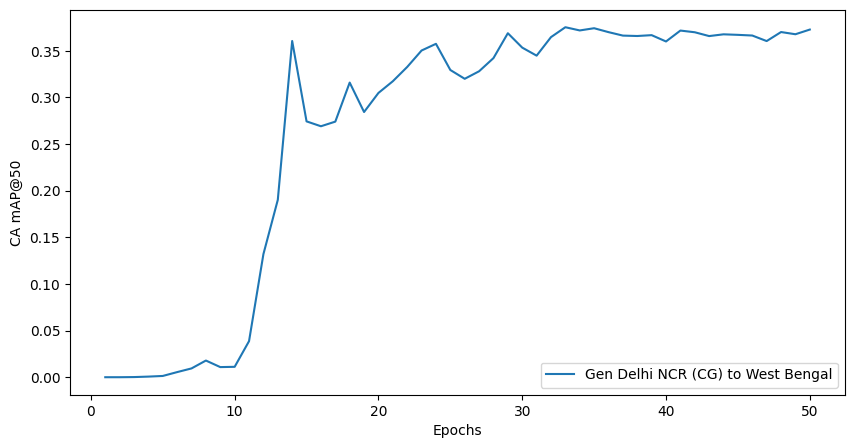

In [13]:
ca_mAP_df = saved_df.reset_index()[["Epochs", "CA mAP@50"]].set_index("Epochs")
# display(ca_mAP_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(ca_mAP_df.index, ca_mAP_df["CA mAP@50"], label=f"{model_config['train']} to {model_config['test']}")
plt.xlabel("Epochs")
plt.ylabel("CA mAP@50")
plt.legend()
plt.savefig(f"../results-{model_config['backbone']}/{model_config['train']}_{model_config['test']}_{model_config['head']}_epoch_results.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# # Filter to include only epochs up to 50
# ca_mAP_df = ca_mAP_df[ca_mAP_df.index <= 50]
# Sort by CA mAP@50 values
sorted_df = ca_mAP_df.sort_values(by="CA mAP@50", ascending=False)
display(sorted_df)

,CA mAP@50
Epochs,
33,0.375274
35,0.374200
50,0.372759
34,0.371822
41,0.371687
48,0.370110
36,0.370007
42,0.369875
29,0.368847


In [15]:
best_epoch = sorted_df.index[0]
print(f"Best epoch: {best_epoch}")
print(f"Best CA mAP@50: {sorted_df.iloc[0, 0]}")

Best epoch: 33
Best CA mAP@50: 0.375274


: 

: 